# Drop to 3 classes
Due to extensive research, I have determined that users do not use their phones upsidedown. Ever. 

#### Imports and functions

In [41]:
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras import layers
from keras.models import Sequential
from keras import callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 3


def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(size, size))
    for ind, title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout()  # optional


def plot_train_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

### Convert the data to only 3 classes

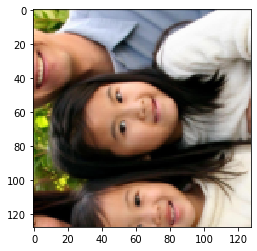

In [68]:
plt.imshow(x_test[330*2])

In [42]:
train_indexes = [i for i in range(len(y_train)) if y_train[i] == 2]
test_indexes = [i for i in range(len(y_test)) if y_test[i] == 2]

x_train = np.delete(x_train, train_indexes, axis=0)
y_train = np.delete(y_train, train_indexes)
x_test = np.delete(x_test, test_indexes, axis=0)
y_test = np.delete(y_test, test_indexes)

len(x_train)

6000

In [69]:
# now renumber the classes
for i in range(len(y_train)):
    if y_train[i] == 3:
        y_train[i] = 2
        
for i in range(len(y_test)):
    if y_test[i] == 3:
        y_test[i] = 2

np.unique(y_train)

array([0, 1, 2], dtype=uint8)

# Current Best - VGG (standardized, Adam) 23,090 - 0.997 (epoch 80)
Scaling - Standardize (subtract mean pixel value and divide by standard deviation)

Optimizer - Adam

#### Define Train function

In [44]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2, channel_shift_range=0.0, fill_mode='nearest', 
                                         horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2,
                                              channel_shift_range=0.0, fill_mode='nearest', horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [45]:
model_6 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(17, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_25 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_31 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 124, 124, 17)      2465      
_________________________________________________________________
batch_normalization_26 (Batc (None, 124, 124, 17)      68        
_________________________________________________________________
activation_32 (Activation)   (None, 124, 124, 17)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 17)       

#### Execute Training

In [46]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_6 = train(model_6, opt=opt)

KeyboardInterrupt: 

In [5]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_23090_9970.h5')

# Test more architectures

## Model 10-1: 3 Class SOTA

#### Define Train function

In [33]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2, channel_shift_range=0.0, fill_mode='nearest', 
                                         horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2,
                                              channel_shift_range=0.0, fill_mode='nearest', horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [73]:
model_10_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(17, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_10_1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_49 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_61 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 124, 124, 17)      2465      
_________________________________________________________________
batch_normalization_50 (Batc (None, 124, 124, 17)      68        
_________________________________________________________________
activation_62 (Activation)   (None, 124, 124, 17)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 17)       

#### Execute Training

In [74]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_10_1 = train(model_10_1, opt=opt)

Epoch 1/200
47/47 [==============================] - 23s 491ms/step - loss: 1.1431 - acc: 0.3384 - val_loss: 1.1047 - val_acc: 0.3253
Epoch 2/200
47/47 [==============================] - 23s 481ms/step - loss: 1.0999 - acc: 0.3405 - val_loss: 1.0988 - val_acc: 0.3444
Epoch 3/200
47/47 [==============================] - 23s 480ms/step - loss: 1.0997 - acc: 0.3367 - val_loss: 1.0993 - val_acc: 0.3303
Epoch 4/200
47/47 [==============================] - 22s 477ms/step - loss: 1.0987 - acc: 0.3353 - val_loss: 1.0981 - val_acc: 0.3394
Epoch 5/200
47/47 [==============================] - 22s 476ms/step - loss: 1.1000 - acc: 0.3269 - val_loss: 1.0981 - val_acc: 0.3404
Epoch 6/200
47/47 [==============================] - 22s 478ms/step - loss: 1.0975 - acc: 0.3422 - val_loss: 1.0966 - val_acc: 0.3444

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/200
47/47 [==============================] - 22s 474ms/step - loss: 1.0969 - acc: 0.3409 - val_loss: 1.0966

47/47 [==============================] - 25s 535ms/step - loss: 0.1787 - acc: 0.9284 - val_loss: 0.1024 - val_acc: 0.9626
Epoch 61/200
42/47 [=========================>....] - ETA: 2s - loss: 0.1709 - acc: 0.9339

KeyboardInterrupt: 

In [ ]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_23090_9970.h5')

#### Predict validation set
Everything looks good. The predictions sum to one and it is predicting the correct class

In [ ]:
train_generator = ImageDataGenerator().flow(x_train, y_train, batch_size=32)

validation_generator = ImageDataGenerator().flow(x_test, y_test, batch_size=32)
batchx, batchy = validation_generator.next()

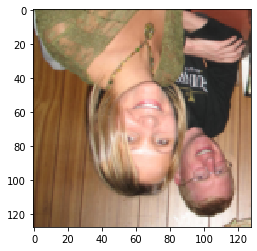

In [23]:
plt.imshow(batchx[3].astype(np.uint8))

In [24]:
batchx_pred = model_1.predict(batchx)
batchx_pred.shape

(32, 4)

In [25]:
batchx_pred[3].argmax()

2

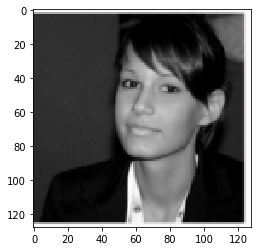

In [27]:
plt.imshow(batchx[0].astype(np.uint8))

In [29]:
batchx_pred[0].argmax()

0

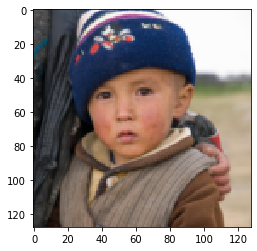

In [31]:
plt.imshow(batchx[1].astype(np.uint8))

In [32]:
batchx_pred[1].argmax()

0

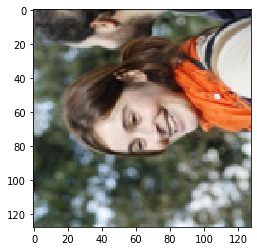

In [33]:
plt.imshow(batchx[2].astype(np.uint8))

In [34]:
batchx_pred[2].argmax()

3

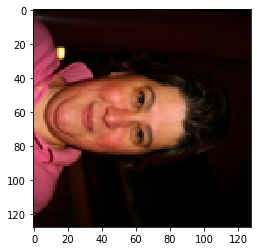

In [36]:
plt.imshow(batchx[5].astype(np.uint8))

In [37]:
batchx_pred[5].argmax()

1

In [30]:
batchx_pred[0].sum()

1.0000001

## Model 10-2:  21,352 - 0.9859 (epoch 49)

#### Define Model

In [86]:
model_10_2 = Sequential([
    Conv2D(12, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(12, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(15, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(15, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(17, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_10_2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 126, 126, 12)      336       
_________________________________________________________________
batch_normalization_115 (Bat (None, 126, 126, 12)      48        
_________________________________________________________________
activation_143 (Activation)  (None, 126, 126, 12)      0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 124, 124, 12)      1308      
_________________________________________________________________
batch_normalization_116 (Bat (None, 124, 124, 12)      48        
_________________________________________________________________
activation_144 (Activation)  (None, 124, 124, 12)      0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 62, 62, 12)      

#### Execute Training

Epoch 1/200
47/47 [==============================] - 25s 540ms/step - loss: 1.1560 - acc: 0.3272 - val_loss: 1.0990 - val_acc: 0.3283
Epoch 2/200
47/47 [==============================] - 23s 489ms/step - loss: 1.1021 - acc: 0.3361 - val_loss: 1.0986 - val_acc: 0.3323
Epoch 3/200
47/47 [==============================] - 24s 513ms/step - loss: 1.1002 - acc: 0.3251 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 4/200
47/47 [==============================] - 24s 509ms/step - loss: 1.0991 - acc: 0.3378 - val_loss: 1.0987 - val_acc: 0.3323
Epoch 5/200
47/47 [==============================] - 24s 511ms/step - loss: 1.0991 - acc: 0.3367 - val_loss: 1.0989 - val_acc: 0.3313
Epoch 6/200
47/47 [==============================] - 24s 520ms/step - loss: 1.0980 - acc: 0.3407 - val_loss: 1.0980 - val_acc: 0.3404
Epoch 7/200
47/47 [==============================] - 24s 501ms/step - loss: 1.0973 - acc: 0.3494 - val_loss: 1.0976 - val_acc: 0.3455
Epoch 8/200
47/47 [==============================] - 24s 501ms

47/47 [==============================] - 25s 541ms/step - loss: 0.1222 - acc: 0.9569 - val_loss: 0.0457 - val_acc: 0.9859
Restoring model weights from the end of the best epoch
Epoch 00059: early stopping


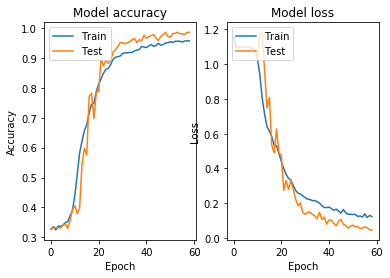

Best val_acc - 0.9859 (epoch 49)


In [87]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_10_2 = train(model_10_2, opt=opt)

In [ ]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_23090_9970.h5')

# Results
The fastest optimizer was Adam, achieving a val_acc of 0.9682 at epoch 28.
The best performing optimizer is also Adam, with a val_acc of 0.9697 at epoch 56 :)